In [1]:
import ROOT
import emm

Welcome to JupyROOT 6.30/04
Top directory: /home/atownse2/Projects


In [2]:
# Get data
data_tree = emm.get_data(sort_and_index=True)
bins = emm.get_fine_binning()

x = ROOT.RooRealVar("x", "Diphoton Mass [GeV]", 500, 6000)
index=ROOT.RooRealVar("index", "index", 0, 0, 1e6)
# data = ROOT.RooDataSet("data", "data", ROOT.RooArgSet(x), ROOT.RooFit.Import(data_tree))
data = ROOT.RooDataSet("mgg", "mgg", ROOT.RooArgSet(x, index), ROOT.RooFit.Import(data_tree))

Loaded 5036 diphoton invariant masses from data.


# Fit Exponential To Subsets

In [3]:
n_events_per_subset = 3
# n_subsets = data.numEntries() // n_events_per_subset
n_subsets = data.numEntries() - n_events_per_subset + 1

rate_scaling = -1/(data.mean(x) - x.getMin())
raw_rate = ROOT.RooRealVar("raw_rate", "raw_rate", 1.0, 0.0, 1e6)
rate = ROOT.RooFormulaVar("rate", f"{rate_scaling}*raw_rate", ROOT.RooArgList(raw_rate))
model = ROOT.RooExponential("model", "Exponential Model", x, rate)

raw_rates = []
failed_fits = 0
for i in range(n_subsets):
    data_subset = data.reduce(f"index>({i}) && index<({i+n_events_per_subset})")
    fit_status = model.fitTo(data_subset, ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save(True), ROOT.RooFit.Strategy(0))
    if fit_status.status() <= 0:
        raw_rates.append(raw_rate.getVal())
    else:
        failed_fits += 1

print(f"Failed fits: {failed_fits} out of {n_subsets}")

Failed fits: 6 out of 5034
[#1] INFO:InputArguments -- The formula index>(0) && index<(3) claims to use the variables (x,index) but only (index) seem to be in use.
  inputs:         index>(0) && index<(3)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (10.3602) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	raw_rate=522.528
RooExponential::model[ x=x c=rate ]
     getLogVal() top-level p.d.f evaluates to zero @ x=x=500.012, c=rate=-2.95606
     getLogVal() top-level p.d.f evaluates to zero @ x=x=500.013, c=rate=-2.95606
RooNLLVar::nll_model_mgg[ parameters=(raw_rate) ]
     function value is NAN @ parameters=(raw_rate = 522.528)

RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (10.3602) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	raw_rate=378.416

0.040262222727994144 260.52662026222555


(0.0, 10.0)

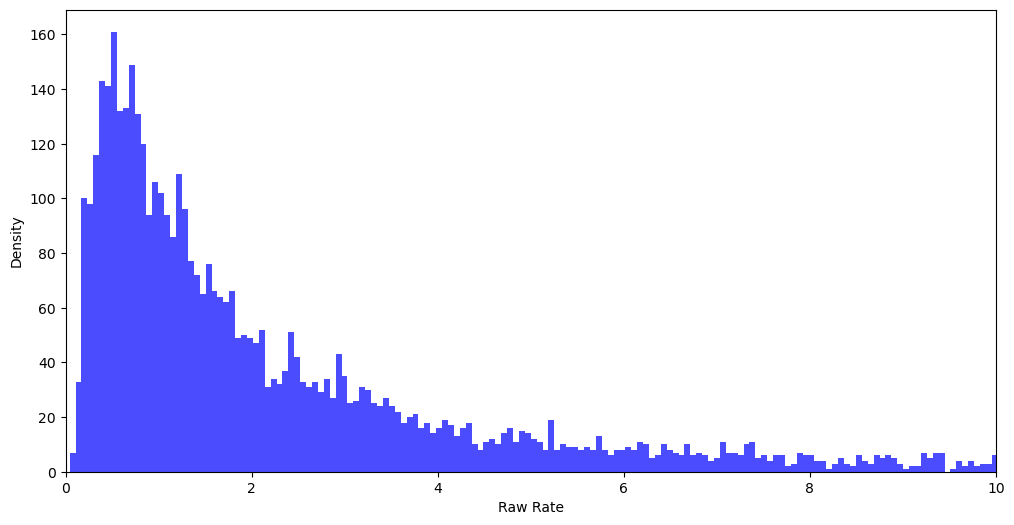

In [4]:
# Draw the histogram of raw rates
import matplotlib.pyplot as plt
print(min(raw_rates), max(raw_rates))
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(raw_rates, bins=4098, density=False, alpha=0.7, color='blue')
ax.set_xlabel('Raw Rate')
ax.set_ylabel('Density')
ax.set_xlim(0, 10)

Fitted in 5.65 seconds
Fit status: 90, covQual: 3
NLL: 10655.642895281337


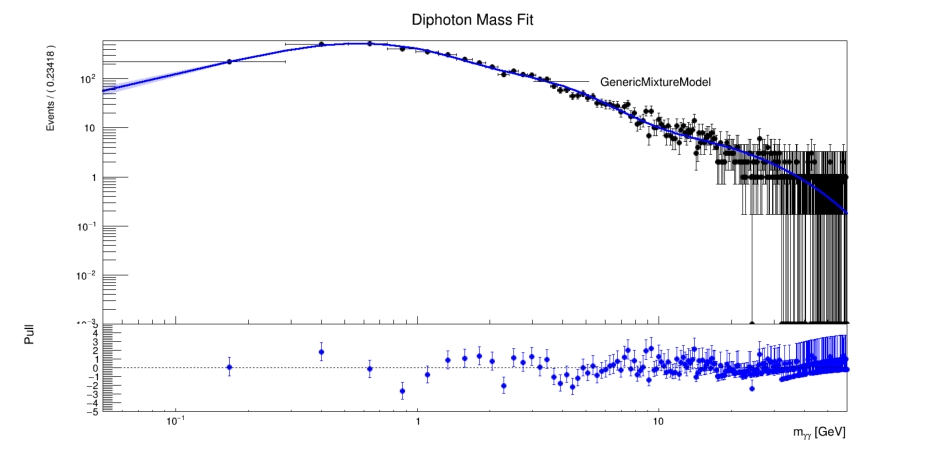

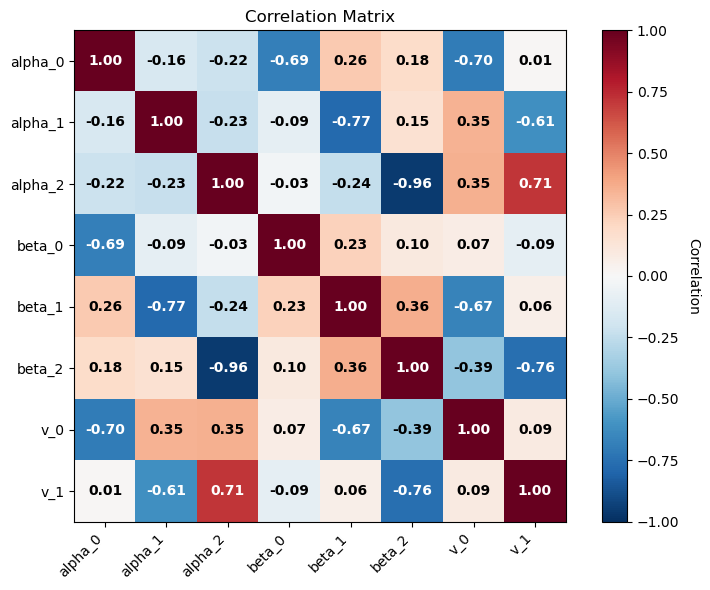

Model: GenericMixtureModel
Number of components: 3
Weights:
  weight_0: 0.1938907460872257 ± N/A
  weight_1: 0.44238714825028974 ± N/A
  weight_2: 0.3637221056624846 ± N/A
Component 0: Alpha=1.0143165083769508, Beta=13.048521654580108, Mu=0.0
Component 1: Alpha=1.932742782089906, Beta=1.4165496483399176, Mu=0.0
Component 2: Alpha=2.887636699833375, Beta=0.2872423610040812, Mu=0.0
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(raw_rate_data) Skipping event #0 because r cannot accommodate the value 260.51
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(raw_rate_data) Skipping event #1 because r cannot accommodate the value 260.51
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(raw_rate_data) Skipping event #2 because r cannot accommodate the value 260.51
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(raw_rate_data) Skipping event #3 because r cannot accommodate the value 260.51
[#1] INFO:DataHandling -- RooTreeDataStore::loadValues(raw_rate_data) Skipping ..

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       16730.90661 Edm =      -882.0221911 NCalls =     37
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 13562.1826
  Edm           : 1949.532931
  Internal parameters:	[     -1.325816225     -1.481323767     -1.481323767     -1.507540228     -1.507540228     -1.507540228                0                0]	
  Internal gradient  :	[      842.1204228      17301.20408      17301.20408     -49100.61459       10693.7788       10693.7788      3576.154768                0]	
  Internal covariance matrix:
[[  9.5157131e-06              0              0              0              0              0              0              0]
 [              0  1.9778046e-06              0              0              0       

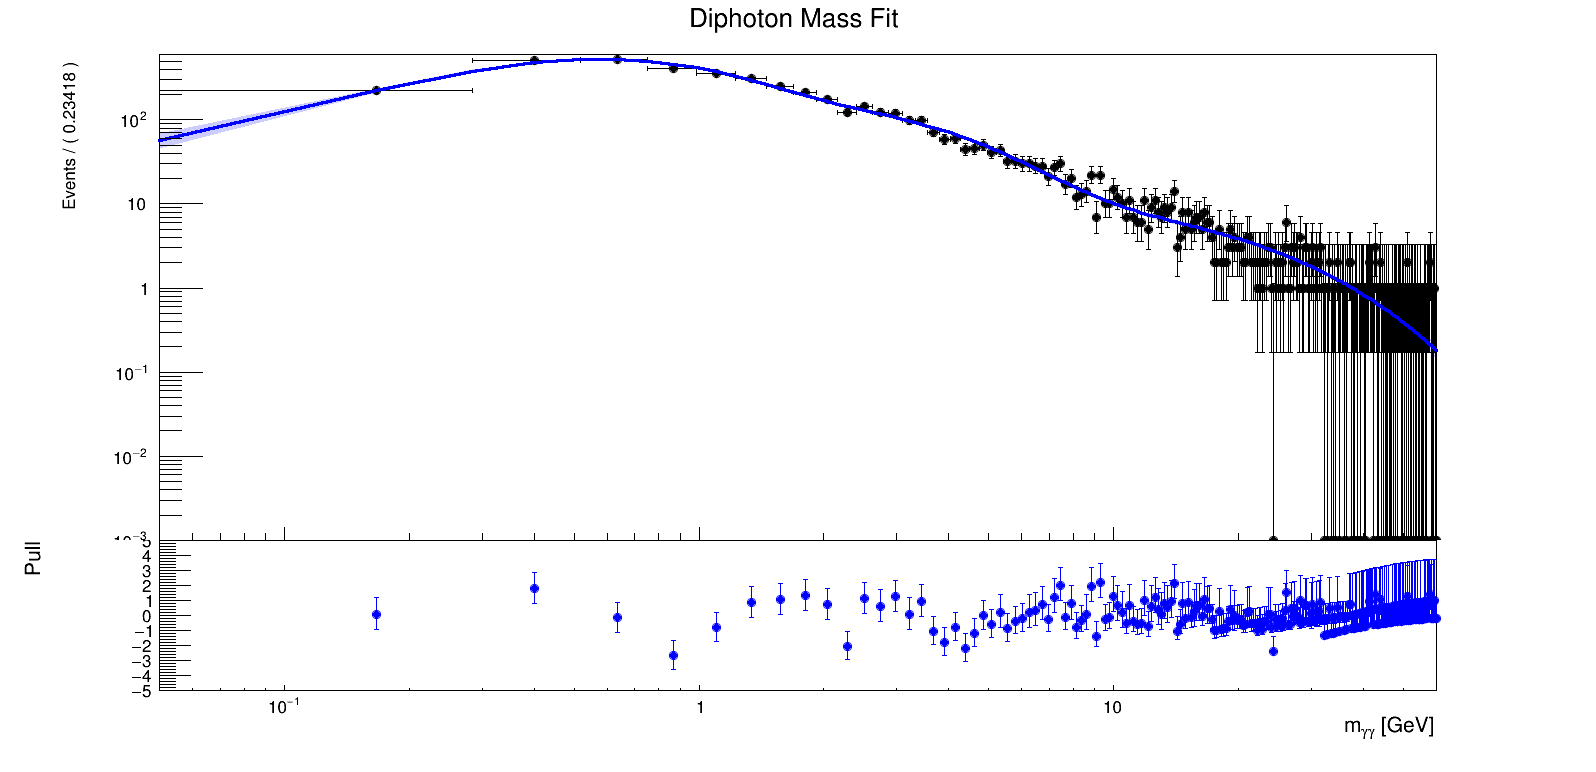

In [6]:
# Load the rates into a RooDataSet
raw_rate_tree = emm.root_tools.to_root_tree([raw_rates], "raw_rate", ["r"], index=True)
r = ROOT.RooRealVar("r", "r", 1, 0.05, 60)
raw_rate_data = ROOT.RooDataSet("raw_rate_data", "Raw Rate Data", ROOT.RooArgSet(r), ROOT.RooFit.Import(raw_rate_tree))

# Fit the raw rates to a Gamma
class Gamma:
    name="Gamma"
    def __init__(self, r):
        self.alpha = ROOT.RooRealVar("alpha", "Alpha", 2, 1, 100000)
        self.beta = ROOT.RooRealVar("beta", "Beta", 1.0, 0, 100000)
        self.mu = ROOT.RooRealVar("mu", "Mu", 0.0)
        self.pdf = ROOT.RooGamma("pdf", "Gamma", r, self.alpha, self.beta, self.mu)

    def print(self):
        print(f"Alpha: {self.alpha.getVal()}, Beta: {self.beta.getVal()}")

class GammaMixture(emm.MixtureModel):
    def init_alphas(self):
        self.alphas = [ROOT.RooRealVar(f"alpha_{i}", f"Alpha {i}", 2, 0, 1000) for i in range(self.n_components)]
    def init_betas(self):
        self.betas = [ROOT.RooRealVar(f"beta_{i}", f"Beta {i}", 1.0, 0, 1000) for i in range(self.n_components)]
    def init_mus(self):
        self.mus = [ROOT.RooRealVar(f"mu_{i}", f"Mu {i}", 0.0) for i in range(self.n_components)]
    def init_pdfs(self, x):
        self.init_alphas()
        self.init_betas()
        self.init_mus()
        self.pdfs = [ROOT.RooGamma(f"pdf_{i}", f"Gamma {i}", x, self.alphas[i], self.betas[i], self.mus[i]) for i in range(self.n_components)]
    def print(self):
        self.print_base()
        for i in range(self.n_components):
            print(f"Component {i}: Alpha={self.alphas[i].getVal()}, Beta={self.betas[i].getVal()}, Mu={self.mus[i].getVal()}")

# model = Gamma(r)
model = GammaMixture(r, n_components=3)

emm.fit_and_plot(
    model, raw_rate_data, r,
    # logx=False,
    logx=True,
    nbins=256
    )


# Stick Breaking vs. Normalization Construction

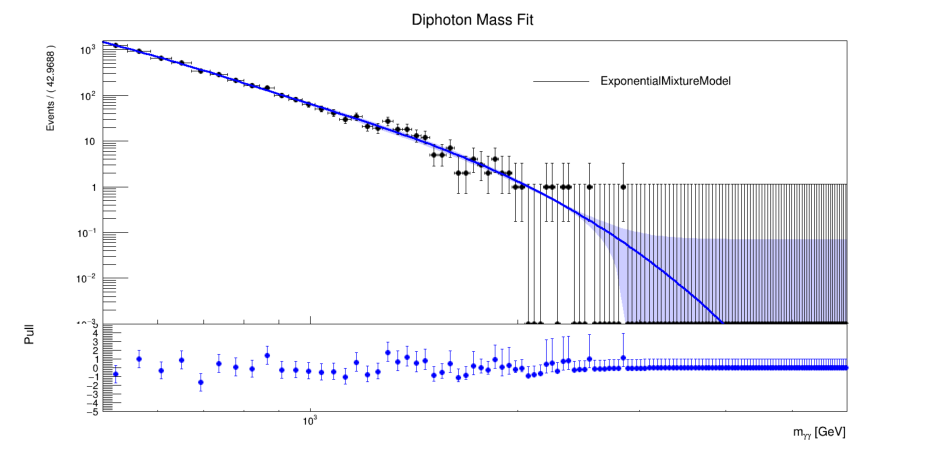

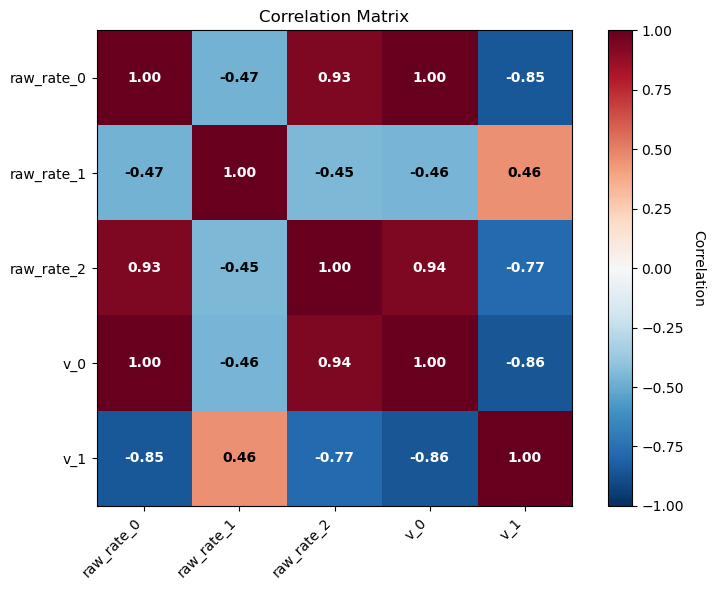

Model: ExponentialMixtureModel
Number of components: 3
Weights:
  weight_0: 0.0035922871651075023 ± N/A
  weight_1: 0.38132126510489817 ± N/A
  weight_2: 0.6150864477299943 ± N/A
Raw Rates:
  raw_rate_0: 0.6686110189878472 ± 53.52160683055391
  raw_rate_1: 0.6418734831939381 ± 0.008718970403705173
  raw_rate_2: 1.5354934286211745 ± 0.0536345964269197
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 2500 convergence for edm < 1 strategy 1
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (34230.9) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	raw_rate_0=1212.23	raw_rate_1=1026.09	raw_rate_2=8921.39	v_0=0.00207498	v_1=0.277404
RooNLLVar::nll_pdf_data[ parameters=(raw_rate_0,raw_rate_1,raw_rate_2,v_0,v_1,v_2) ]
     function value is NAN @ parameters=(raw_rate_0 = 1212.23,raw_rate_1 = 1026.09,ra

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       34108.70567 Edm =        2792.51583 NCalls =     23
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31061.37881
  Edm           : 120.906054
  Internal parameters:	[     -1.589791746     -1.550795993     -1.542511113                0                0]	
  Internal gradient  :	[     -25633.71602      8001.454826     -453.6870565     -33.58005215     -13.01145392]	
  Internal covariance matrix:
[[  1.2064352e-07              0              0              0              0]
 [              0  6.0871163e-06              0              0              0]
 [              0              0  1.9086028e-06              0              0]
 [              0              0              0   0.0098309705           

In [50]:
model = emm.ExponentialMixtureModel(x, 3, data_mean=data.mean(x))
emm.fit_and_plot(model, data, x)

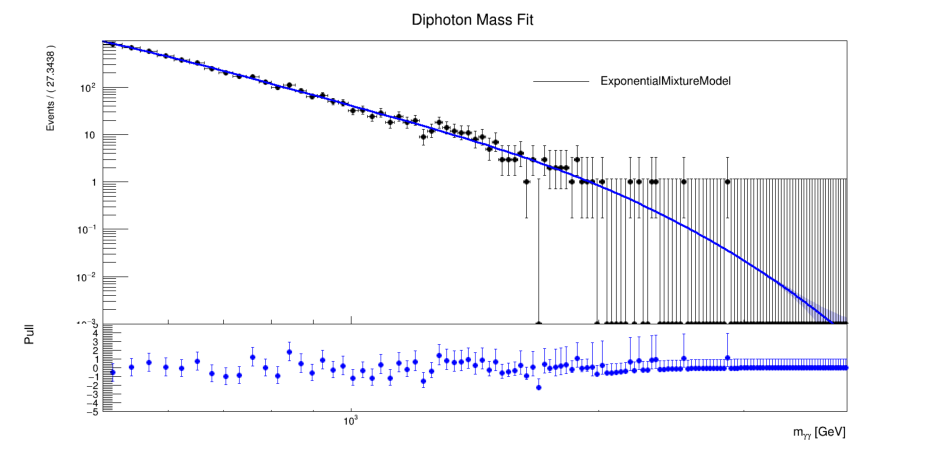

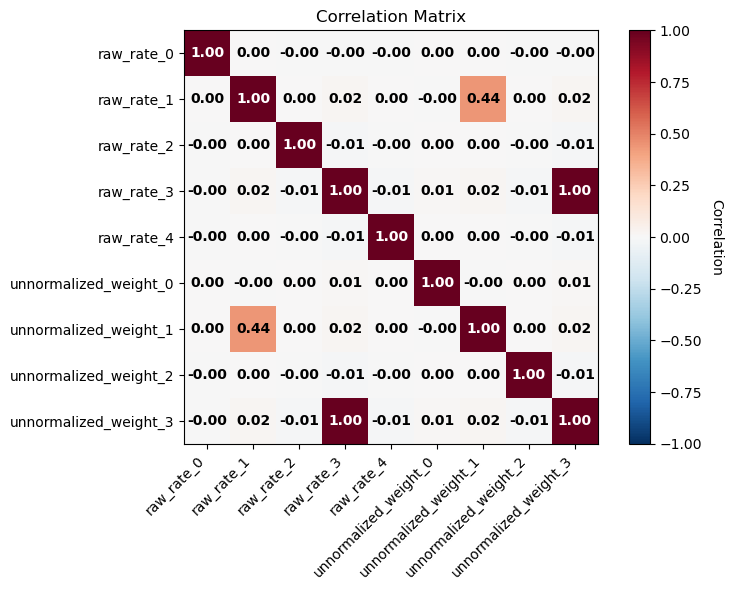

Model: ExponentialMixtureModel
Number of components: 5
Weights:
  weight_0: 0.38615102952077374 ± N/A
  weight_1: 3.742358469317803e-05 ± N/A
  weight_2: 0.40049677517247934 ± N/A
  weight_3: 1.4909730617155794e-05 ± N/A
  weight_4: 0.21329986199143655 ± N/A
Raw Rates:
  raw_rate_0: 0.6426781119841622 ± 0.0004505492058752836
  raw_rate_1: 1.8774349365719278 ± 5.880190121469515
  raw_rate_2: 1.53627297630145 ± 0.001736072766641561
  raw_rate_3: 0.8775541100823273 ± 760.344388581608
  raw_rate_4: 1.5386056317963068 ± 0.0032480176510351066
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 4500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 1
FVAL  = 31030.8263765076845
Edm   = 5.28643515732631463e-06
Nfcn  = 935
raw_rate_0	  = 0.642678	 +/-  0.00210752	(limited)
raw_rate_1	  = 1.87743	 +/-  14.3949	(limited)
raw_rate_2	  = 1.53627	 +/-

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       32494.36328 Edm =       1295.074159 NCalls =     39
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31107.46966
  Edm           : 428.9684815
  Internal parameters:	[     -1.527393708     -1.507540228     -1.481323767     -1.508066175     -1.444220741     -1.507540228     -1.507540228     -1.507540228     -1.507540228]	
  Internal gradient  :	[     -4433.790907      1451.538777      2818.950674      1381.820805      2226.236926     -1002.492674     -1498.854657      490.5124329     -1522.415844]	
  Internal covariance matrix:
[[  1.3776217e-06              0              0              0              0              0              0              0              0]
 [              0  6.6497661e-06  

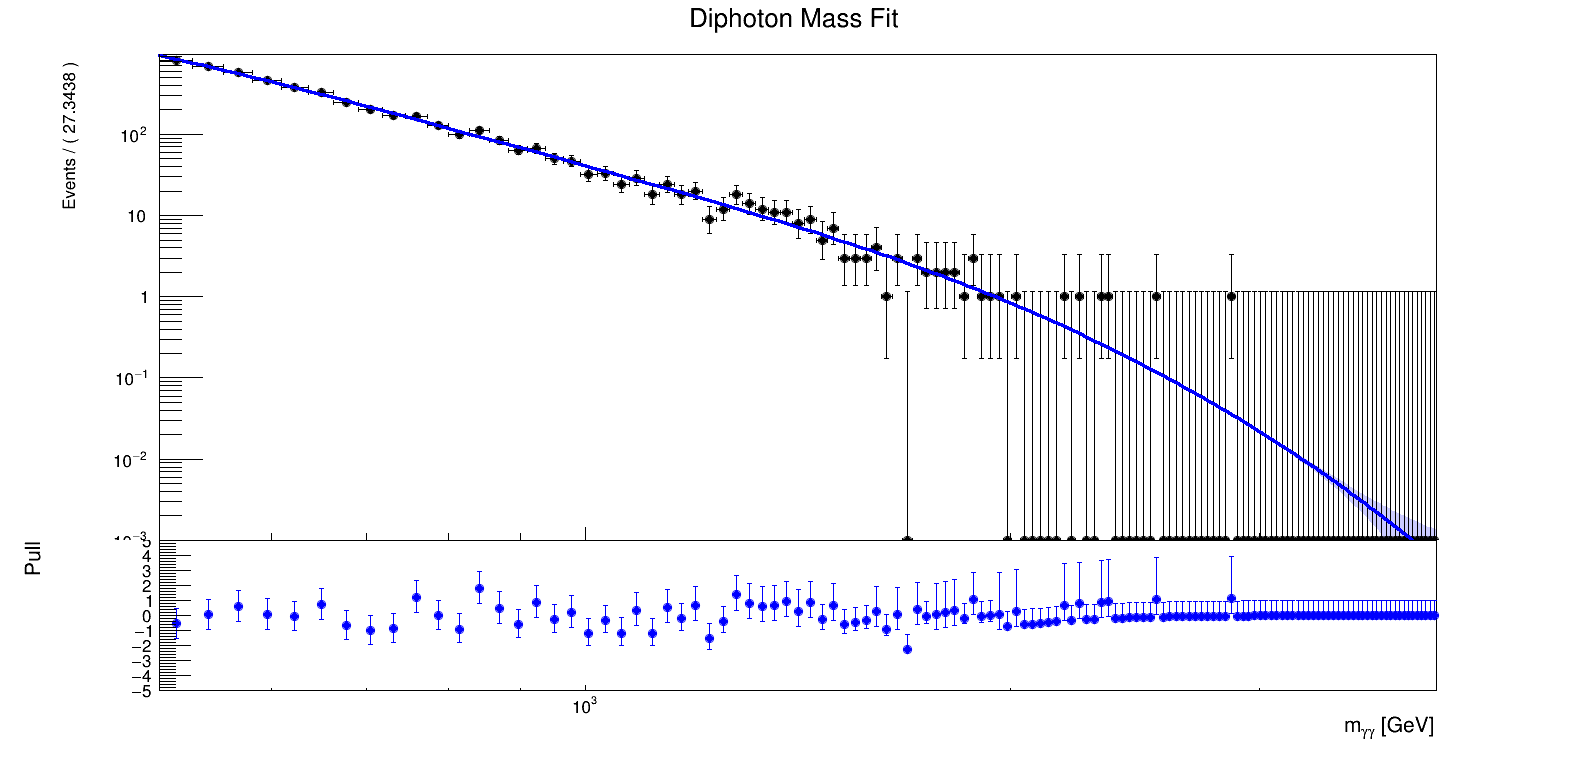

In [16]:
model = emm.ExponentialMixtureModel(x, 5, data_mean=data.mean(x), use_normalization_construction=True)
emm.fit_and_plot(model, data, x)

# Fit Status and Complexity

# Bounded vs. Exponential Transform

Fitted ExponentialMixtureModel in 5.30 seconds
Fit status: 491, covQual: 2
NLL: 31030.832541225718


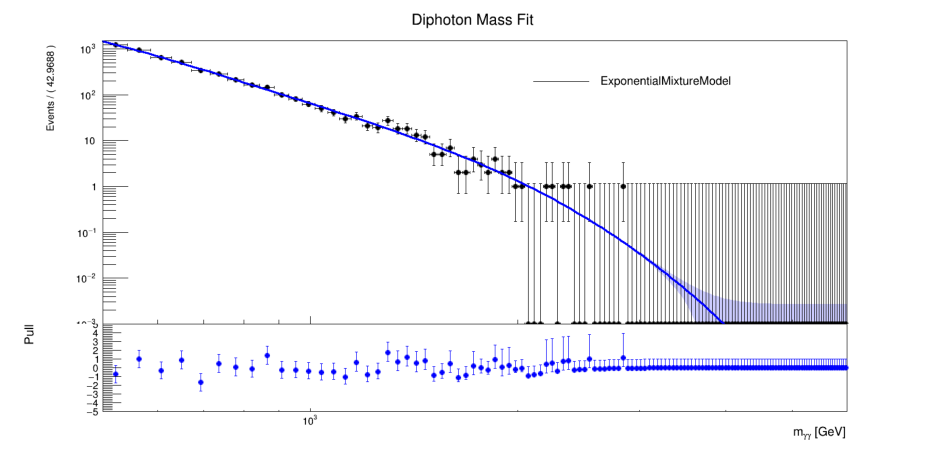

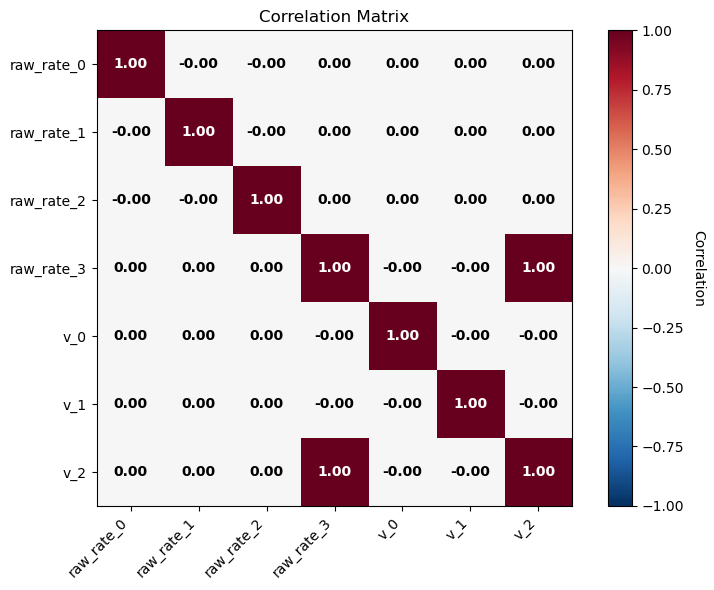

Model: ExponentialMixtureModel
Number of components: 4
Weights:
  weight_0: 0.1023490759774594 ± N/A
  weight_1: 0.28209386187699487 ± N/A
  weight_2: 0.6154215291932378 ± N/A
  weight_3: 0.0001355329523078487 ± N/A
Raw Rates:
  raw_rate_0: 0.657048678301762 ± 0.00106515404167562
  raw_rate_1: 0.6367065082922224 ± 0.00035990851235406796
  raw_rate_2: 1.5342925681252397 ± 0.0006760716405175282
  raw_rate_3: 1.5561838062064446 ± 29.650966075067636
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 3500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 1
FVAL  = 31030.8325412257182
Edm   = 3.27788087639494941e-08
Nfcn  = 806
raw_rate_0	  = 0.657049	 +/-  0.00106515	(limited)
raw_rate_1	  = 0.636707	 +/-  0.000359909	(limited)
raw_rate_2	  = 1.53429	 +/-  0.000676072	(limited)
raw_rate_3	  = 1.55618	 +/-  29.651	(limited)
v_0	  = 0.102349	 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       34213.76131 Edm =       804.3480075 NCalls =     29
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31058.27496
  Edm           : 71.99297176
  Internal parameters:	[      -1.58955284     -1.550795993     -1.542511113     -1.536153578                0                0                0]	
  Internal gradient  :	[     -25575.38029      7896.377244      1046.005691      1184.738398     -59.60745468     -34.45778449     -7.083444394]	
  Internal covariance matrix:
[[  1.0973926e-07              0              0              0              0              0              0]
 [              0  2.3120573e-06              0              0              0              0              0]
 [              0      

In [4]:
model = emm.ExponentialMixtureModel(x, 4, data_mean=data.mean(x))
emm.fit_and_plot(model, data, x)

Fitted ExponentialMixtureModel in 6.77 seconds
Fit status: -1, covQual: 2
NLL: 31030.635268651306


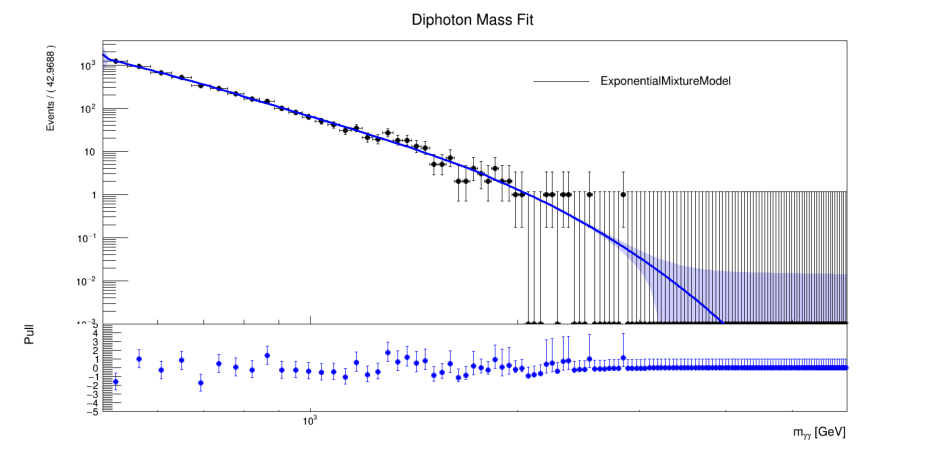

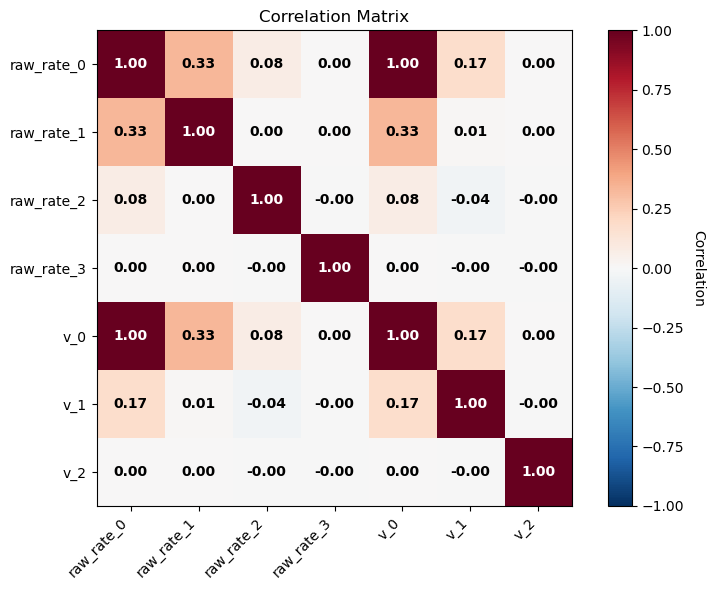

Model: ExponentialMixtureModel
Number of components: 4
Weights:
  weight_0: 0.0008324405124542863 ± N/A
  weight_1: 0.6174350589677458 ± N/A
  weight_2: 0.38068506461049023 ± N/A
  weight_3: 0.0010474359093097254 ± N/A
Raw Rates:
  raw_rate_0: 5.561973683578141 ± 10.207289100487118
  raw_rate_1: 0.42332798641186015 ± 0.007648926492056816
  raw_rate_2: -0.44524659359920715 ± 0.007067406534331531
  raw_rate_3: -0.4364735291476863 ± 0.011419335003815057
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 3500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 1
FVAL  = 31030.8326160557808
Edm   = 0.000204388544890975394
Nfcn  = 922
raw_rate_0	  = -0.126038	 +/-  5.51651
raw_rate_1	  = 0.428771	 +/-  0.0281541
raw_rate_2	  = -0.441397	 +/-  0.266392
raw_rate_3	  = -0.461551	 +/-  2.86803
v_0	  = 0.00165766	 +/-  0.198678	(limited)
v_1	  = 0.6

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       31096.40623 Edm =  -1.231589451e-05 NCalls =     31
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31035.07958
  Edm           : 7.026083971
  Internal parameters:	[                0     0.5961236315    -0.6991889417                0                0                0                0]	
  Internal gradient  :	[     -37.71780965     -32.58793478      1.154262435     -9.433798306      16.31444851     -18.26541795     0.9741650194]	
  Internal covariance matrix:
[[   0.0019456102              0              0              0              0              0              0]
 [              0   0.0087419651              0              0              0              0              0]
 [              0      

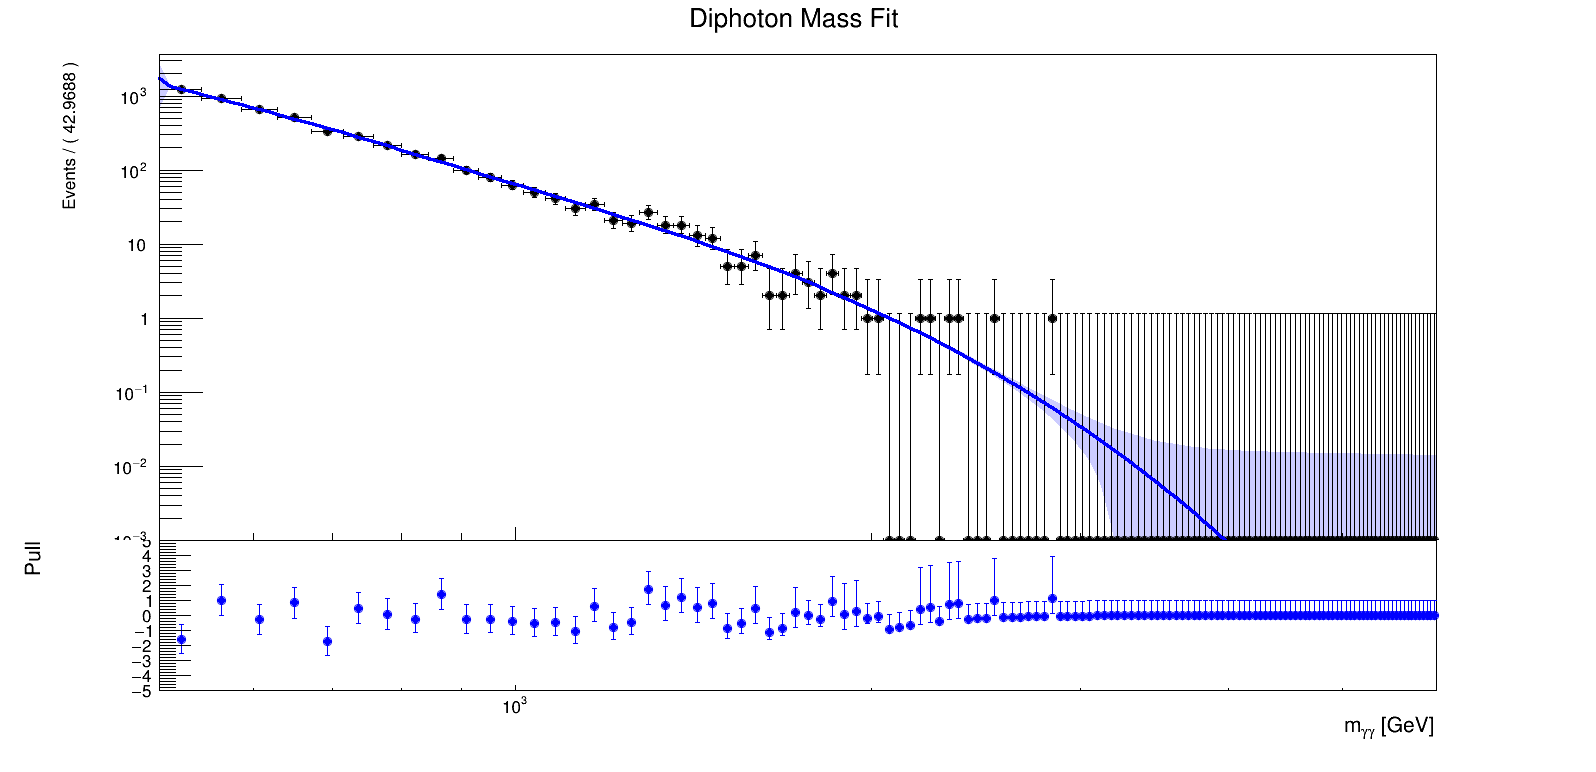

In [3]:
model = emm.ExponentialMixtureModel(x, 4, data_mean=data.mean(x), exponential_transform=True)
emm.fit_and_plot(model, data, x)

# Unordered vs. Ordered

Fitted ExponentialMixtureModel in 5.95 seconds
Fit status: 431, covQual: 2
NLL: 31030.83198789914


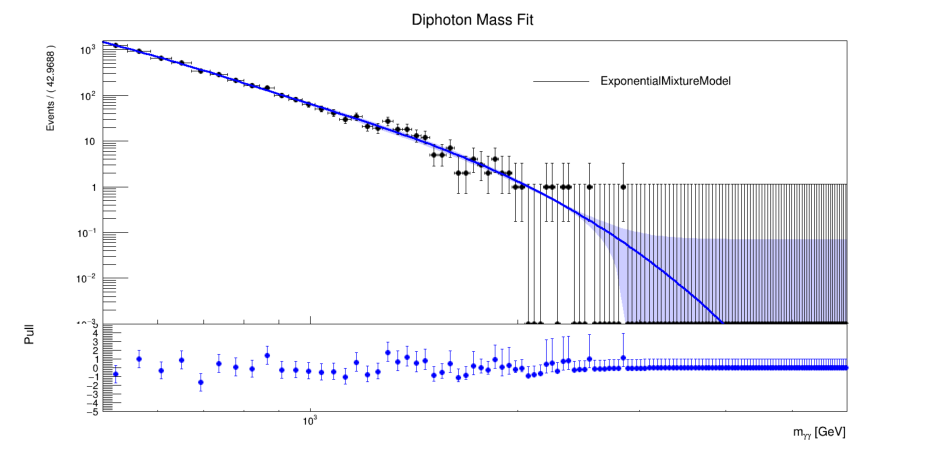

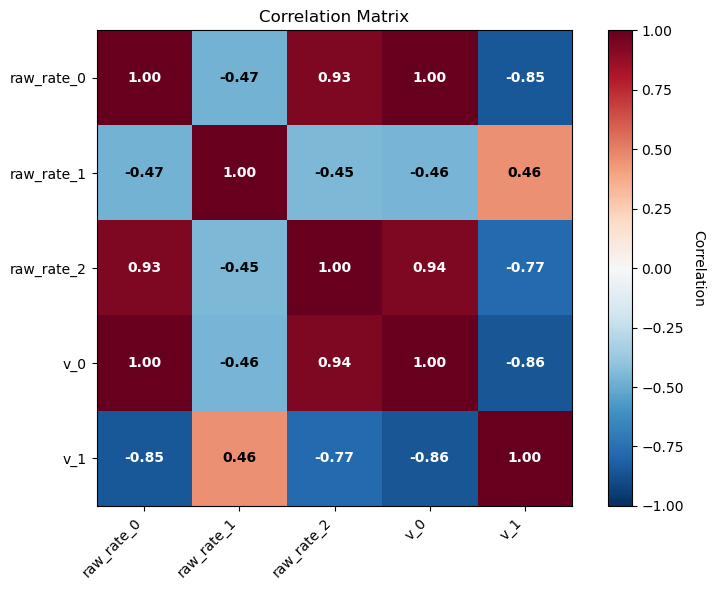

Model: ExponentialMixtureModel
Number of components: 3
Weights:
  weight_0: 0.0035922871651075023 ± N/A
  weight_1: 0.38132126510489817 ± N/A
  weight_2: 0.6150864477299943 ± N/A
Raw Rates:
  raw_rate_0: 0.6686110189878472 ± 53.52160683055391
  raw_rate_1: 0.6418734831939381 ± 0.008718970403705173
  raw_rate_2: 1.5354934286211745 ± 0.0536345964269197
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 2500 convergence for edm < 1 strategy 1
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (34230.9) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	raw_rate_0=1212.23	raw_rate_1=1026.09	raw_rate_2=8921.39	v_0=0.00207498	v_1=0.277404
RooNLLVar::nll_pdf_data[ parameters=(raw_rate_0,raw_rate_1,raw_rate_2,v_0,v_1,v_2) ]
     function value is NAN @ parameters=(raw_rate_0 = 1212.23,raw_rate_1 = 1026.09,ra

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       34108.70567 Edm =        2792.51583 NCalls =     23
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31061.37881
  Edm           : 120.906054
  Internal parameters:	[     -1.589791746     -1.550795993     -1.542511113                0                0]	
  Internal gradient  :	[     -25633.71602      8001.454826     -453.6870565     -33.58005215     -13.01145392]	
  Internal covariance matrix:
[[  1.2064352e-07              0              0              0              0]
 [              0  6.0871163e-06              0              0              0]
 [              0              0  1.9086028e-06              0              0]
 [              0              0              0   0.0098309705           

In [32]:
model = emm.ExponentialMixtureModel(x, 3, data_mean=data.mean(x))
emm.fit_and_plot(model, data, x)

Fitted ExponentialMixtureModel in 0.34 seconds
Fit status: 160, covQual: 3
NLL: 31030.831984493598


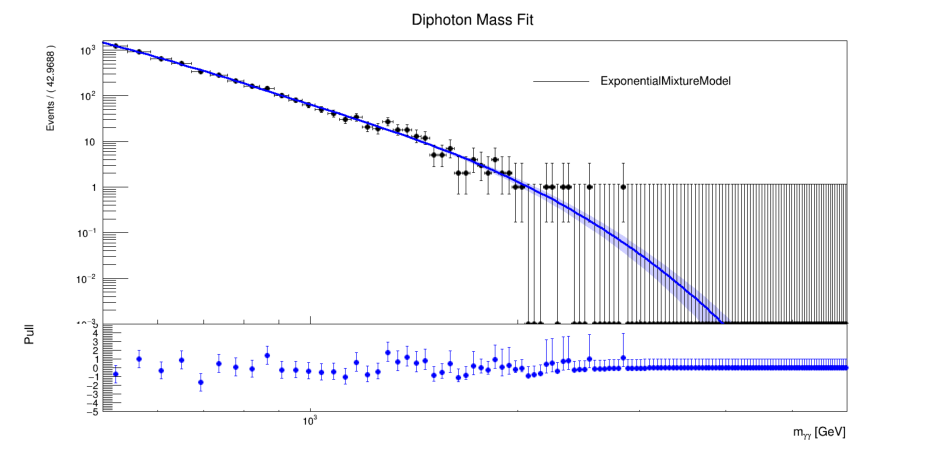

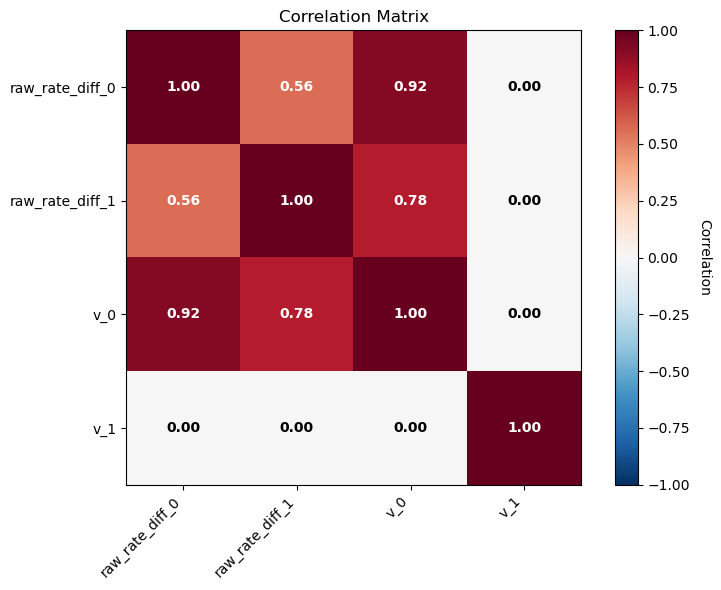

Model: ExponentialMixtureModel
Number of components: 3
Weights:
  weight_0: 0.6144588934312432 ± N/A
  weight_1: 0.19277055328437842 ± N/A
  weight_2: 0.19277055328437842 ± N/A
Raw Rate Differences:
  raw_rate_diff_0: 0.6508321119448265 ± 0.04509124708301199
  raw_rate_diff_1: 0.9052860231746236 ± 0.08389082767709682
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 2000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = 31030.8319844935977
Edm   = 7.77532332528403273e-05
Nfcn  = 81
raw_rate_diff_0	  = 0.650832	 +/-  0.0450912	(limited)
raw_rate_diff_1	  = 0.905286	 +/-  0.0838908	(limited)
v_0	  = 0.614459	 +/-  0.0724153	(limited)
v_1	  = 0.5	 +/-  0.420735	(limited)
******************************************************************************************************
Minuit2Minimizer::GetMinosError - Run MINOS LOWER error f

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       31363.29388 Edm =       1128.485401 NCalls =     17
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31363.29388
  Edm           : 1128.485401
  Internal parameters:	[     -1.550795993     -1.550795993                0                0]	
  Internal gradient  :	[      110341.1302      38467.99514     -520.7964574                0]	
  Internal covariance matrix:
[[  1.3787136e-07              0              0              0]
 [              0   9.047833e-07              0              0]
 [              0              0   0.0055172901              0]
 [              0              0              0              2]]]
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 31363.29388
  Ed

In [30]:
model = emm.ExponentialMixtureModel_Ordered(x, 3, data_mean=data.mean(x))
emm.fit_and_plot(model, data, x)

# Unpenalized vs. Penalized

## Unordered

Fitted in 0.97 seconds
Fit status: -1, covQual: 1
NLL: 31030.83488337395


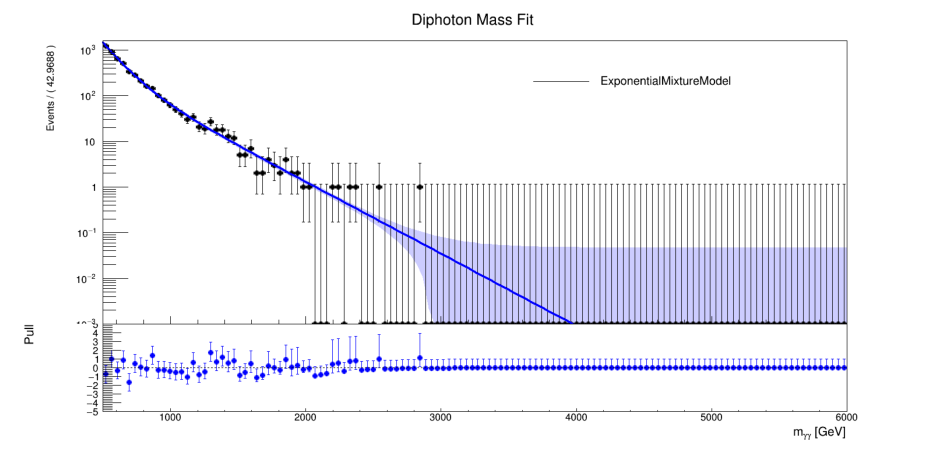

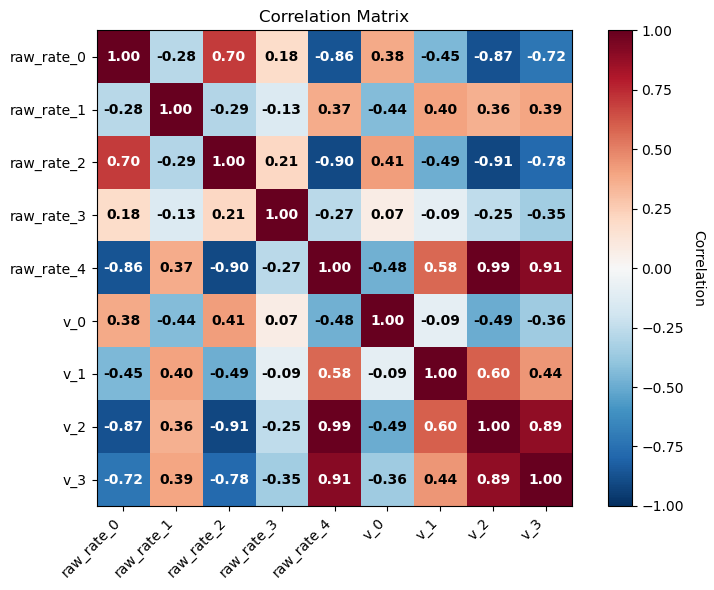

Model: ExponentialMixtureModel
Number of components: 5
Weights:
  weight_0: 0.07008621616078561 ± N/A
  weight_1: 0.3837669466007988 ± N/A
  weight_2: 0.5422555382042747 ± N/A
  weight_3: 0.0021712841921849723 ± N/A
  weight_4: 0.0017200148419559155 ± N/A
Raw Rates:
  raw_rate_0: 1.4436339929625308 ± 0.7815016004706723
  raw_rate_1: 0.6420824243256716 ± 0.018586862795292536
  raw_rate_2: 1.5476518159397348 ± 0.1284237342079535
  raw_rate_3: 0.8532333366471985 ± 0.8969975500631295
  raw_rate_4: 1.629650713447383 ± 81.2880511987241
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 4500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Invalid Minimum - status = 3
FVAL  = 31030.8
Edm   = 0.00568166
Nfcn  = 662
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:NumericIntegr

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       34254.73684 Edm =       1864.733737 NCalls =     39
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31040.47077
  Edm           : 34.62119654
  Internal parameters:	[     -1.591029142     -1.554950388     -1.542511113     -1.536153578      -1.53079366                0                0                0                0]	
  Internal gradient  :	[     -588.4478959      2279.011022      1247.760531      858.3958736      892.8042669     -21.58224472     -28.64903713     -14.45964892     -4.730664593]	
  Internal covariance matrix:
[[  1.9315922e-07              0              0              0              0              0              0              0              0]
 [              0  1.6603992e-07  

In [6]:
model = emm.ExponentialMixtureModel(x, 5, data_mean=data.mean(x))
emm.fit_and_plot(model, data, x)

Fitted in 27.27 seconds
Fit status: 1500, covQual: 3
NLL: 31030.835620531816
Penalty: 1.1793288689213176e-05


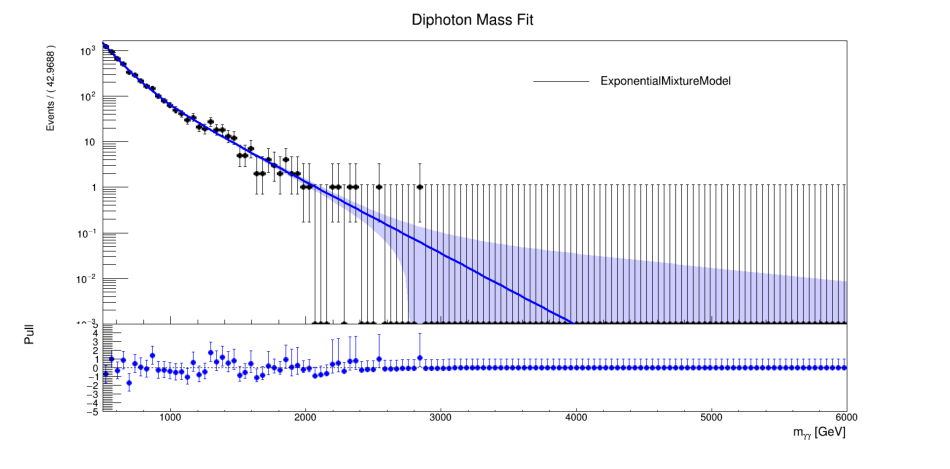

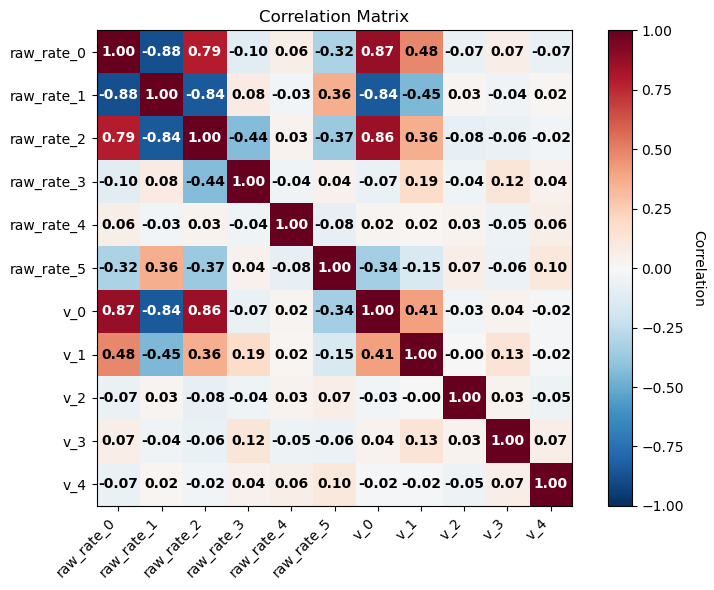

Model: ExponentialMixtureModel
Number of components: 6
Weights:
  weight_0: 0.3811815243966165 ± N/A
  weight_1: 0.23635480820246427 ± N/A
  weight_2: 0.25769560512964373 ± N/A
  weight_3: 0.1195727709364001 ± N/A
  weight_4: 4.32886892131759e-05 ± N/A
  weight_5: 0.005152002645662092 ± N/A
Raw Rates:
  raw_rate_0: 0.6401061210195441 ± 0.035796646604589144
  raw_rate_1: 1.5010582224460864 ± 0.19110540729606385
  raw_rate_2: 1.5687894932958983 ± 0.4023217094006756
  raw_rate_3: 1.515080221831933 ± 0.3895276726893916
  raw_rate_4: 1.86076939216086 ± 0.9413186910514977
  raw_rate_5: 1.2952231960228775 ± 1.1716316184465683
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:Minimization -- RooFormulaVar::defaultErrorLevel(nll_penalty) Formula contains a RooNLLVar, using its error level
Minuit2Minimizer: Minimize with max-calls 5500 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - 

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       34271.14133 Edm =       2192.861592 NCalls =     47
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31052.68688
  Edm           : 52.70605896
  Internal parameters:	[     -1.587606159     -1.550795993     -1.542511113     -1.536153578      -1.53079366      -1.52607124                0                0                0                0....                 0]	
  Internal gradient  :	[      16543.53007     -6632.924939      156.9831631      687.4464473      434.5606224       449.102137      61.35243968       12.1372438     -11.84741293     -6.369779985....      -2.093221282]	
  Internal covariance matrix:
[[  8.0060091e-08              0              0              0              0              0   

In [6]:
model = emm.ExponentialMixtureModel(x, 6, data_mean=data.mean(x))
# p = emm.unordered_penalty(model.rates, model.weights, penalty_strength=0.000001)
# p = emm.weight_penalty(model.weights, penalty_strength=0.0001)
p = emm.SCAD_penalty(model.weights, penalty_strength=0.001)
emm.fit_and_plot(model, data, x, penalty=p)

## Ordered

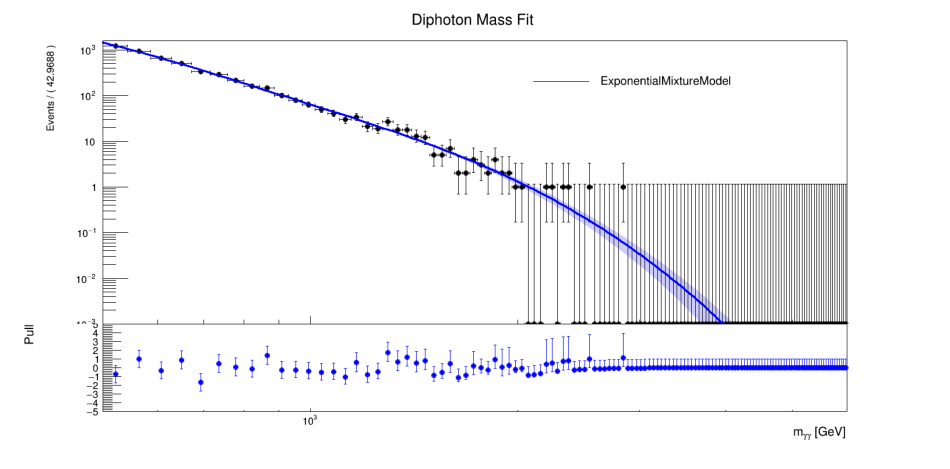

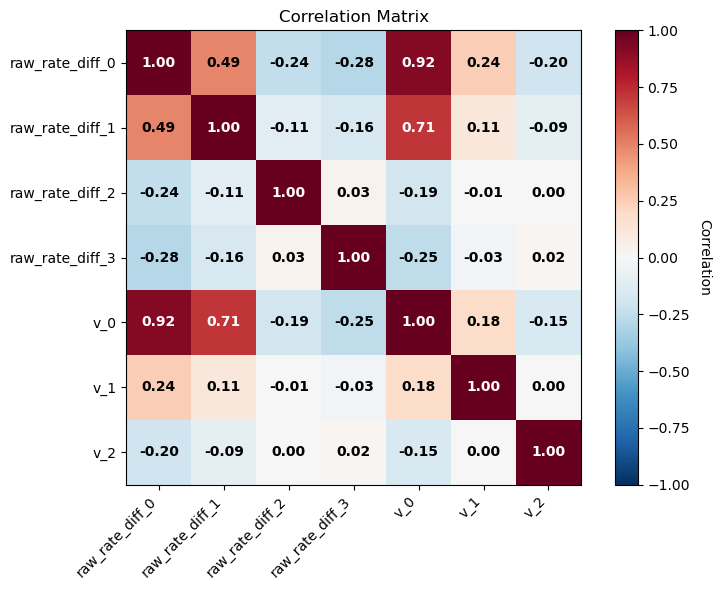

Model: ExponentialMixtureModel
Number of components: 4
Weights:
  weight_0: 0.38706025255898 ± N/A
  weight_1: 0.5859652293857083 ± N/A
  weight_2: 0.003263675427779255 ± N/A
  weight_3: 0.023710842627532473 ± N/A
Raw Rate Differences:
  raw_rate_diff_0: 0.6435282896759259 ± 0.04481212293205433
  raw_rate_diff_1: 0.8922262620123285 ± 0.08857365486334473
  raw_rate_diff_2: 0.05499289662122937 ± 0.05515065430333871
  raw_rate_diff_3: 0.0008735280594219033 ± 0.04648507585471295


Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       31315.81482 Edm =       1064.690972 NCalls =     27
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 31315.81482
  Edm           : 1064.690972
  Internal parameters:	[     -1.550795993     -1.550795993     -1.550795993     -1.550795993                0                0                0]	
  Internal gradient  :	[      131146.4362      19579.97594      5936.962113      2317.939722     -646.3957169      -127.585255     -28.88753647]	
  Internal covariance matrix:
[[  5.6969118e-08              0              0              0              0              0              0]
 [              0  2.4555169e-06              0              0              0              0              0]
 [              0              0  1.0918341e-05              0              0              0              0]
 [              0              0         

In [51]:
model = emm.ExponentialMixtureModel_Ordered(x, 4, data_mean=data.mean(x))
emm.fit_and_plot(model, data, x)

31030.834938617965 0.004731351887470384 31030.839669969853


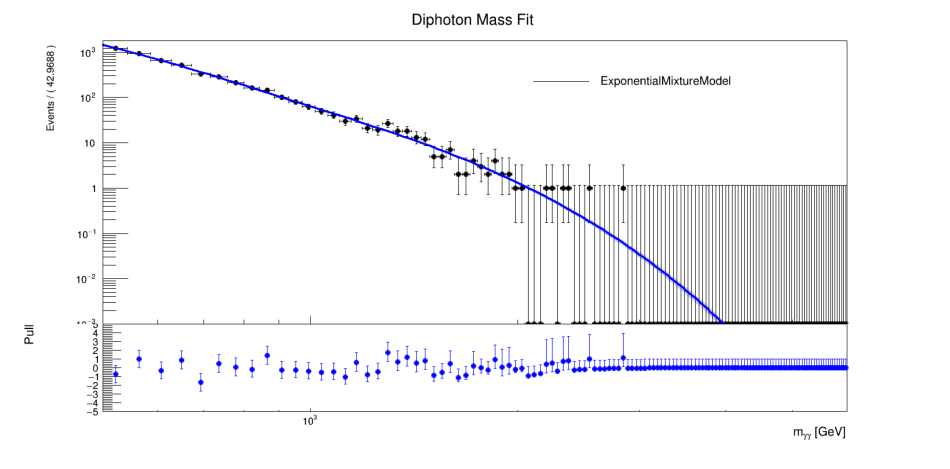

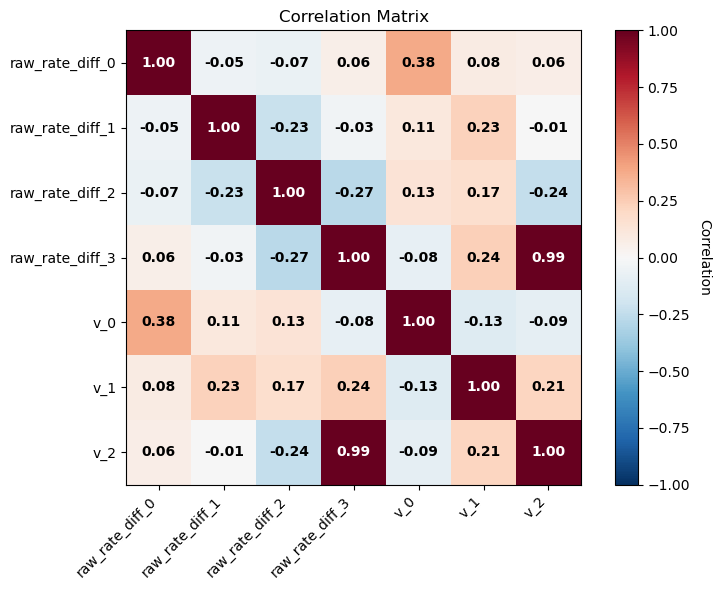

Model: ExponentialMixtureModel
Number of components: 4
Weights:
  weight_0: 0.38405846088996326 ± N/A
  weight_1: 0.21557695024397322 ± N/A
  weight_2: 0.23149628962392182 ± N/A
  weight_3: 0.16886829924214164 ± N/A
Raw Rate Differences:
  raw_rate_diff_0: 0.6418287422654324 ± 0.01250090342529403
  raw_rate_diff_1: 0.8506081646131308 ± 0.042786166719687546
  raw_rate_diff_2: 0.04041156537763475 ± 0.06914814709636623
  raw_rate_diff_3: 0.05344085883297932 ± 8.368144105966838


Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       31315.81484 Edm =       1064.689264 NCalls =     27
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 31315.81484
  Edm           : 1064.689264
  Internal parameters:	[     -1.550795993     -1.550795993     -1.550795993     -1.550795993                0                0                0]	
  Internal gradient  :	[      131146.4358      19579.97513      5936.960512      2317.938114     -646.3956989      -127.585243     -28.88753661]	
  Internal covariance matrix:
[[  5.6969118e-08              0              0              0              0              0              0]
 [              0  2.4555163e-06              0              0              0              0              0]
 [              0              0  1.0918317e-05              0              0              0              0]
 [              0              0         

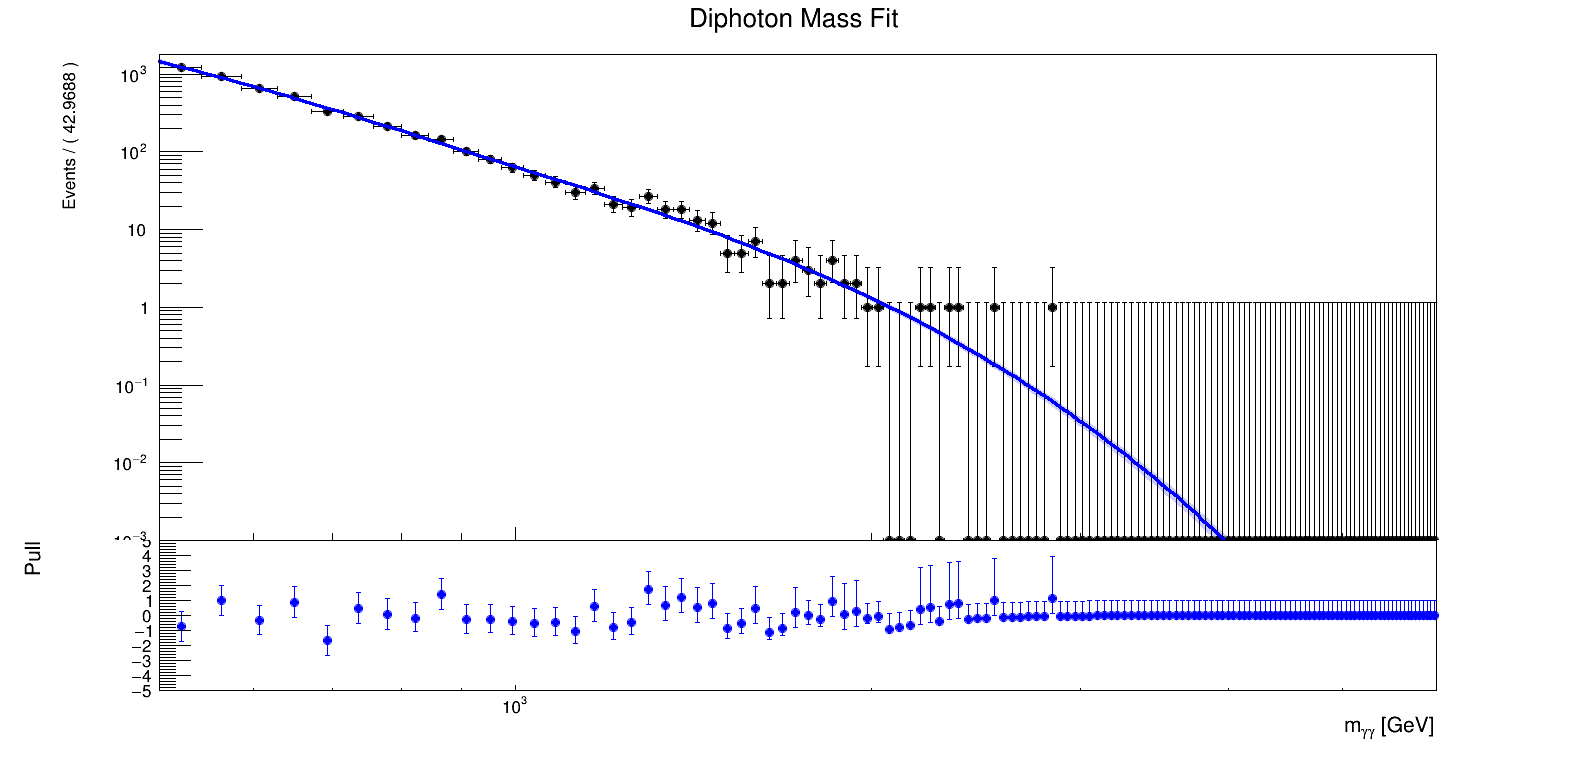

In [59]:
model = emm.ExponentialMixtureModel_Ordered(x, 4, data_mean=data.mean(x))
p = emm.ordered_penalty(model.raw_rate_diffs, model.weights, penalty_strength=0.000001)
emm.fit_and_plot(model, data, x, penalty=p)

# Mixture of Lomax?

In [23]:
# Mixture of Lomax

class LomaxMixtureModel(emm.MixtureModel):
    name = "LomaxMixtureModel"
    def init_alphas(self, x):
        self.alphas = [
            ROOT.RooRealVar(
                f"alpha_{i}", f"Shape parameter {i}",
                3+i, 0.01, 10000
            ) for i in range(self.n_components)
        ]
    
    def init_betas(self, x):
        self.betas = [
            ROOT.RooRealVar(
                f"beta_{i}", f"Scale parameter {i}",
                0.005, 0.000001, 10
            ) for i in range(self.n_components)
        ]

    def init_pdfs(self, x):
        self.init_alphas(x)
        self.init_betas(x)
        
        self.pdfs = [
            ROOT.RooGenericPdf(
                f"pdf_{i}", f"Lomax {i}",
                f"(alpha_{i}*beta_{i}) * (1 + x*beta_{i})^(-alpha_{i}-1)",
                ROOT.RooArgList(
                    x,
                    self.betas[i],
                    self.alphas[i],
                )
            ) for i in range(self.n_components)
        ]
    
    def print(self):
        self.print_base()
        for i in range(self.n_components):
            print(f"Component {i}: alpha = {self.alphas[i].getVal()}, beta = {self.betas[i].getVal()}")


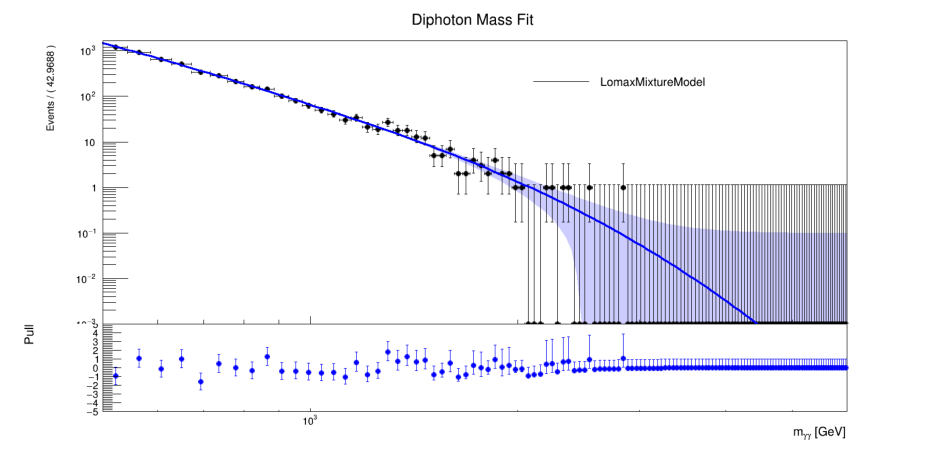

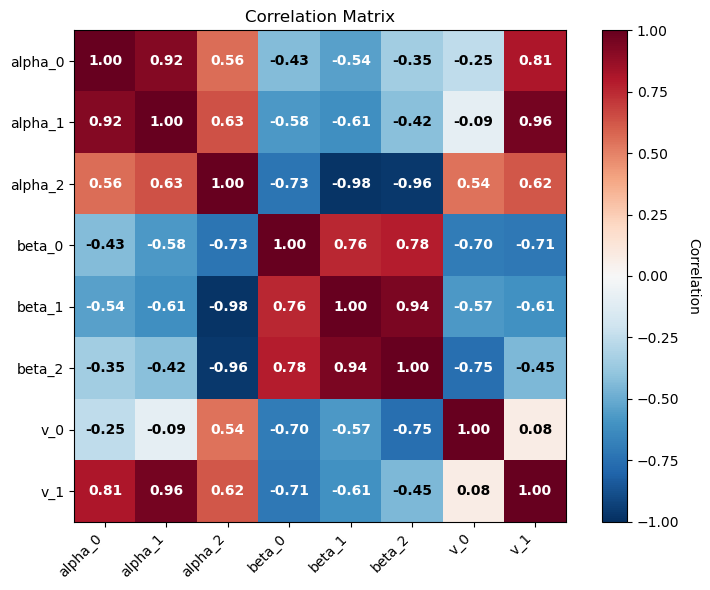

Model: LomaxMixtureModel
Number of components: 3
Weights:
  weight_0: 0.6445282114781585 ± N/A
  weight_1: 0.005088019803190147 ± N/A
  weight_2: 0.35038376871865134 ± N/A
Component 0: alpha = 14.702071321847342, beta = 0.0007998516182507123
Component 1: alpha = 6.309378536249688, beta = 1.653481867949413
Component 2: alpha = 27.632214008225688, beta = 0.00015057561038249898
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_0_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_1_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_2_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 4000 convergence for edm < 1 strategy 1
Minuit

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       31250.70224 Edm =       885.1776401 NCalls =     33
Info in <Minuit2>: MnSeedGenerator Initial state  
  Minimum value : 31250.70224
  Edm           : 885.1776401
  Internal parameters:	[     -1.536211353     -1.530843681     -1.526115972     -1.526075711     -1.526075711     -1.526075711                0                0]	
  Internal gradient  :	[     -40544.73974     -14731.81071     -11019.90409      -7165.98931     -3089.281679     -2652.423838      247.1798504       60.4067551]	
  Internal covariance matrix:
[[  4.5886775e-07              0              0              0              0              0              0              0]
 [              0  1.4700472e-06              0              0              0              0              0              0]
 [              0              0  1.8612129e-06              0              0         

In [29]:
model = LomaxMixtureModel(x, 3)
emm.fit_and_plot(model, data, x)

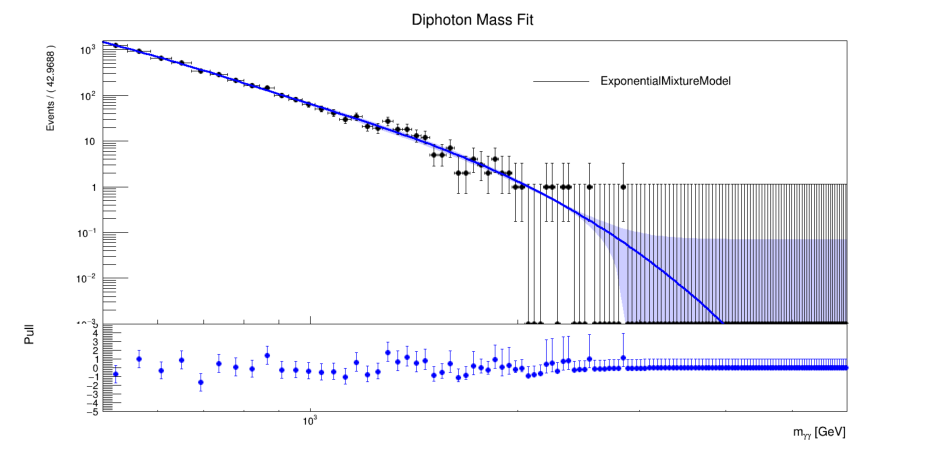

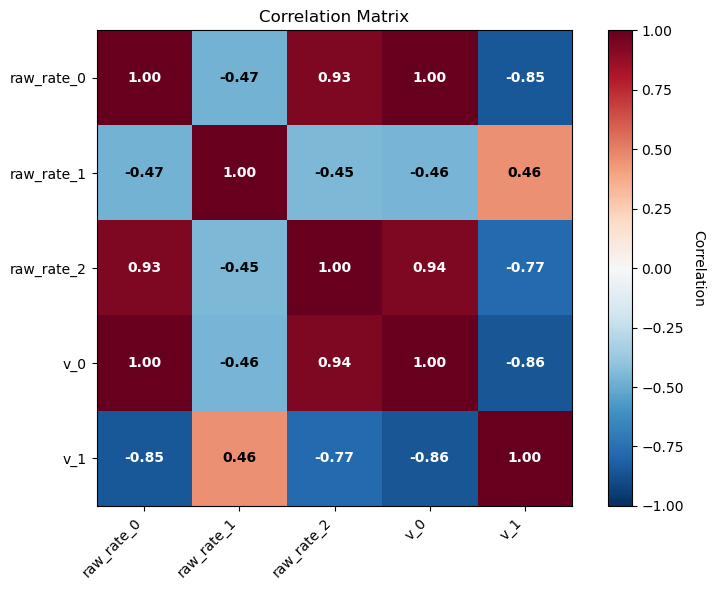

Model: ExponentialMixtureModel
Number of components: 3
Weights:
  weight_0: 0.0035922871651075023 ± N/A
  weight_1: 0.38132126510489817 ± N/A
  weight_2: 0.6150864477299943 ± N/A
Raw Rates:
  raw_rate_0: 0.6686110189878472 ± 53.52160683055391
  raw_rate_1: 0.6418734831939381 ± 0.008718970403705173
  raw_rate_2: 1.5354934286211745 ± 0.0536345964269197
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pdf_Int[x]) using numeric integrator RooRombergIntegrator to calculate Int(x)
Minuit2Minimizer: Minimize with max-calls 2500 convergence for edm < 1 strategy 1
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (34230.9) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	raw_rate_0=1212.23	raw_rate_1=1026.09	raw_rate_2=8921.39	v_0=0.00207498	v_1=0.277404
RooNLLVar::nll_pdf_data[ parameters=(raw_rate_0,raw_rate_1,raw_rate_2,v_0,v_1,v_2) ]
     function value is NAN @ parameters=(raw_rate_0 = 1212.23,raw_rate_1 = 1026.09,ra

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =       34108.70567 Edm =        2792.51583 NCalls =     23
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : 31061.37881
  Edm           : 120.906054
  Internal parameters:	[     -1.589791746     -1.550795993     -1.542511113                0                0]	
  Internal gradient  :	[     -25633.71602      8001.454826     -453.6870565     -33.58005215     -13.01145392]	
  Internal covariance matrix:
[[  1.2064352e-07              0              0              0              0]
 [              0  6.0871163e-06              0              0              0]
 [              0              0  1.9086028e-06              0              0]
 [              0              0              0   0.0098309705           

In [39]:
model = emm.ExponentialMixtureModel(x, 3, data_mean=data.mean(x))
emm.fit_and_plot(model, data, x)